# Flow over a cylinder with source-panels
What if we want to represent the stream lines around an *arbitrary* geometry? Would you be able to define the combination of fundamental solutions to get the expected result? *How could you do that?* Trial and error? It would take enormous luck and a lot of work to get a geometry we want.

The objective is to calculate the source-strength distribution that can produce potential flow around a given geometry: a circular cylinder. We know that we can get the flow around a cylinder by superposing a doublet in a free stream, but here we want to develop a more general approach that can later be extended to *different* shapes.

The method we will use consists of representing the geometry of the body by a series of short linear segments, called *panels*, that correspond to source sheets like we studied in the previous lesson.

In [9]:
import math
import numpy
from scipy import integrate
from matplotlib import pyplot

In [2]:
N = 100                               # Number of points in each direction
x_start, x_end = -1.0, 1.0            # x-direction boundaries
y_start, y_end = -1.5, 1.5            # y-direction boundaries
x = numpy.linspace(x_start, x_end, N)    # computes a 1D-array for x
y = numpy.linspace(y_start, y_end, N)    # computes a 1D-array for y
X, Y = numpy.meshgrid(x, y)              # generates a mesh grid

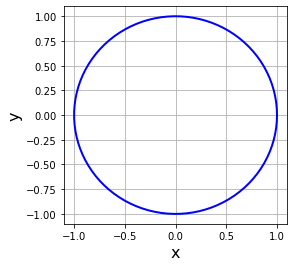

In [3]:
u_inf = 1.0     # free-stream speed
# define the cylinder of untit radius centered at (0, 0)
R = 1.0
x_center, y_center = 0.0, 0.0
theta = numpy.linspace(0.0, 2 * math.pi, 100)
x_cylinder, y_cylinder = (x_center + R * numpy.cos(theta),
                          y_center + R * numpy.sin(theta))

# plot the cylinder
size = 4
pyplot.figure(figsize=(size, size))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.plot(x_cylinder, y_cylinder, color='b', linestyle='-', linewidth=2)
pyplot.xlim(-1.1, 1.1)
pyplot.ylim(-1.1, 1.1);

*italicized text*### Discretization into panels

A panel, which represents a source sheet, is defined by its two end-points (`xa`, `ya`) and (`xb`, `yb`) and its strength `sigma`. We'll also need its center point (`xc`, `yc`) and its length for further calculations. The orientation of the panel is defined by the angle between the $x$-axis and its normal in the counter-clockwise sense.

What information do we need to compute on each panel? First of all, we will need the strength of the source sheet that will lead to the correct streamlines. In addition, we'll also want the tangential velocity (the normal velocity on the body is zero for an inviscid flow) and the pressure coefficient.

In this lesson, you'll really appreciate having learned about classes. It will make the code so much easier to manage. We create a class named `Panel` containing all the geometry data related to one panel. With a start- and end-point, the class internally calculates the center-point, length and normal vector. It also initializes to zero the source strength, tangential velocity and pressure coefficient. (These will be updated later.)

In [4]:
class Panel:
    """
    Contains information related to a panel.
    """
    def __init__(self, xa, ya, xb, yb):
        """
        Initializes the panel.

        Sets the end-points and calculates the center, length, and angle
        (with the x-axis) of the panel.
        Initializes the strength of the source-sheet, the tangential velocity,
        and the pressure coefficient to zero.

        Parameters
        ----------
        xa: float
            x-coordinate of the first end-point.
        ya: float
            y-coordinate of the first end-point.
        xb: float
            x-coordinate of the second end-point.
        yb: float
            y-coordinate of the second end-point.
        """
        self.xa, self.ya = xa, ya
        self.xb, self.yb = xb, yb

        self.xc, self.yc = (xa + xb) / 2, (ya + yb) / 2  # control-point (center-point)
        self.length = math.sqrt((xb - xa)**2 + (yb - ya)**2)  # length of the panel

        # orientation of the panel (angle between x-axis and panel's normal)
        if xb - xa <= 0.:
            self.beta = math.acos((yb - ya) / self.length)
        elif xb - xa > 0.:
            self.beta = math.pi + math.acos(-(yb - ya) / self.length)

        self.sigma = 0.0  # source strength
        self.vt = 0.0  # tangential velocity
        self.cp = 0.0  # pressure coefficient


To store all the discretization, we create a NumPy array of size `N_panels` where each item in the array is an object of type `Panel`.

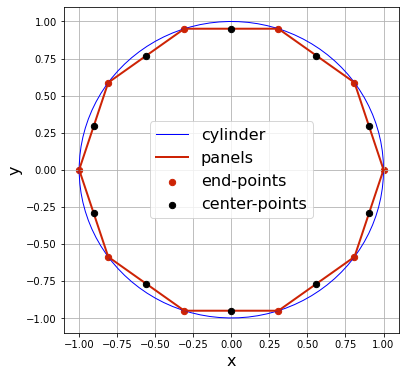

In [6]:
N_panels = 10  # number of panels desired

# define the end-points of the panels
x_ends = R * numpy.cos(numpy.linspace(0.0, 2 * math.pi, N_panels + 1))
y_ends = R * numpy.sin(numpy.linspace(0.0, 2 * math.pi, N_panels + 1))

# define the panels
panels = numpy.empty(N_panels, dtype=object)
for i in range(N_panels):
    panels[i] = Panel(x_ends[i], y_ends[i], x_ends[i + 1], y_ends[i + 1])

# plot the panels
size = 6
pyplot.figure(figsize=(size, size))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.plot(x_cylinder, y_cylinder,
            label='cylinder',
            color='b', linestyle='-', linewidth=1)
pyplot.plot(x_ends, y_ends,
            label='panels',
            color='#CD2305', linestyle='-', linewidth=2)
pyplot.scatter([p.xa for p in panels], [p.ya for p in panels],
               label='end-points',
               color='#CD2305', s=40)
pyplot.scatter([p.xc for p in panels], [p.yc for p in panels],
               label='center-points',
               color='k', s=40, zorder=3)
pyplot.legend(loc='best', prop={'size':16})
pyplot.xlim(-1.1, 1.1)
pyplot.ylim(-1.1, 1.1);

### Flow-tangency boundary condition
previously you worked out the velocity potential of a single source. It followed simply from integrating the radial velocity, $u_r=\frac{\sigma}{2\pi r}$, that

$$\phi=\frac{\sigma}{2\pi}\ln r$$

(The integration also gives a function of $\theta$ that is seen to be a constant because $u_{\theta}=0$; we take this constant to be zero.)

We will use the velocity potential in this lesson to easily express that the velocity be tangent at the panel, i.e., that $u_n=0$ with:

$$u_n(x,y)=\frac{\partial \phi}{\partial n}(x,y)$$

at a given point on the panel. We choose the point to enforce that velocity-tangency condition as the center of the panel (and we call it the *control point*).

The velocity potential in Cartesian coordinates of a source sheet on a panel is

$$\phi\left(x,y\right) = \frac{\sigma}{2\pi} \int_\text{panel} \ln \sqrt{ \left(x-x(s)\right)^2 + \left(y-y(s)\right)^2 } {\rm d}s$$

where $s$ is the running coordinate along the panel and $\left(x(s),y(s)\right)$ are the Cartesian coordinates of $s$.

Superposition of the potential of each panel gives the total potential at any point $\left(x,y\right)$, so we make a sum of all the panel contributions as follows (moving the $\frac{1}{2}$ exponent in the logarithmic term as a factor outside the integral):

Enforcing the flow-tangency condition on each *control point* approximately makes the body geometry correspond to a dividing streamline (and the approximation improves if we represent the body with more and more panels). So, for each panel $i$, we make $u_n=0$ at $(x_{c_i},y_{c_i})$:

$$u_{n_i} = \frac{\partial}{\partial n_i}\left\lbrace \phi\left(x_{c_i},y_{c_i}\right) \right\rbrace = 0$$

which leads to

$$
0 = U_\infty \cos\beta_i + \sum_{j=1}^{N_p} \frac{\sigma_j}{2\pi} \int \frac{\left(x_{c_i}-x_j(s_j)\right) \frac{\partial x_{c_i}}{\partial n_i} + \left(y_{c_i}-y_j(s_j)\right) \frac{\partial y_{c_i}}{\partial n_i}} {\left(x_{c_i}-x_j(s)\right)^2 + \left(y_{c_i}-y_j(s)\right)^2} {\rm d}s_j
$$

where $\beta_i$ is the angle that the panel's normal makes with the $x$-axis, so

$$\frac{\partial x_{c_i}}{\partial n_i} = \cos\beta_i \quad \text{and}\quad\frac{\partial y_{c_i}}{\partial n_i} = \sin\beta_i$$

and

$$x_j(s_j) = x_{a_j} - \sin\left(\beta_j\right) s_j$$
$$y_j(s_j) = y_{a_j} + \cos\left(\beta_j\right) s_j$$

But, there is still a problem to handle when $i=j$. From the previous notebook, we have seen that the strength of the source sheet should be a specific value so that the streamlines do not penetrate the panel. This helps us determine that the contribution of the $i$-th panel to itself is $\frac{\sigma_i}{2}$.

Finally, the boundary condition at the center point of the $i$-th panel gives

$$
0 = U_\infty \cos\beta_i + \frac{\sigma_i}{2} + \sum_{j=1,j\neq i}^{N_p} \frac{\sigma_j}{2\pi} \int \frac{\left(x_{c_i}-x_j(s_j)\right) \cos\beta_i + \left(y_{c_i}-y_j(s_j)\right) \sin\beta_i} {\left(x_{c_i}-x_j(s)\right)^2 + \left(y_{c_i}-y_j(s)\right)^2} {\rm d}s_j
$$

From the equation above, we understand that we will have to compute integrals using the SciPy function `integrate.quad()`. We define a function `integral_normal()` that will do the job.

In [7]:
def integral_normal(p_i, p_j):
    """
    Evaluates the contribution of a panel at the center-point of another,
    in the normal direction.

    Parameters
    ----------
    p_i: Panel object
        Panel on which the contribution is calculated.
    p_j: Panel object
        Panel from which the contribution is calculated.

    Returns
    -------
    Integral over the panel at the center point of the other.
    """
    def integrand(s):
        return (((p_i.xc - (p_j.xa - math.sin(p_j.beta) * s)) * math.cos(p_i.beta) +
                 (p_i.yc - (p_j.ya + math.cos(p_j.beta) * s)) * math.sin(p_i.beta)) /
                ((p_i.xc - (p_j.xa - math.sin(p_j.beta) * s))**2 +
                 (p_i.yc - (p_j.ya + math.cos(p_j.beta) * s))**2))
    return integrate.quad(integrand, 0.0, p_j.length)[0]

### Solving the system of equations
We just developed an equation to enforce a flow-tangency condition on the $i$-th panel. There are `N_panels` panels $i$ and `N_panels` unknown strengths $\sigma_i$. Therefore, the problem represents solving a linear system of equations of the form

$$[A][\sigma] = [b]$$

where

$$
A_{ij} = \begin{cases}
\begin{matrix}
\frac{1}{2} & \mbox{, if } i=j \cr
\frac{1}{2\pi} \int \frac{\left(x_{c_i}-x_j(s_j)\right) \cos\beta_i + \left(y_{c_i}-y_j(s_j)\right) \sin\beta_i} {\left(x_{c_i}-x_j(s)\right)^2 + \left(y_{c_i}-y_j(s)\right)^2} ds_j & \mbox{, if } i\neq j
\end{matrix}
\end{cases}
$$

and

$$b_i = - U_\infty \cos\beta_i$$

for $1\leq i,j \leq N_p$. Let's fill a matrix $A$ and a right-hand side vector $b$ with the necessary values:

In [10]:
# compute the source influence matrix
A = numpy.empty((N_panels, N_panels), dtype=float)
numpy.fill_diagonal(A, 0.5)

for i, p_i in enumerate(panels):
    for j, p_j in enumerate(panels):
        if i != j:
            A[i, j] = 0.5 / math.pi * integral_normal(p_i, p_j)

# compute the RHS of the linear system
b = - u_inf * numpy.cos([p.beta for p in panels])

Now, we can easily solve the linear system of equations using the function [`linalg.solve()`](http://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.solve.html) from NumPy, and assign each source-panel its appropriate strength:

In [11]:
# solve the linear system
sigma = numpy.linalg.solve(A, b)

for i, panel in enumerate(panels):
    panel.sigma = sigma[i]

### Pressure coefficient on the surface
At this point, we have the source strength distribution required to compute the streamlines around our geometry. A very useful measurement of the results is the pressure coefficient along the surface of the geometry.

From Bernoulli's equation, the pressure coefficient on the $i$-th panel is

$$C_{p_i} = 1-\left(\frac{u_{t_i}}{U_\infty}\right)^2$$

where $u_{t_i}$ is the tangential component of the velocity at the center point of the $i$-th panel,

$$u_{t_i} = \frac{\partial}{\partial t_i}\left\lbrace \phi\left(x_{c_i},y_{c_i}\right) \right\rbrace$$

which we can obtain as:

$$
u_{t_i} = -U_\infty \sin\beta_i + \sum_{j=1}^{N_p} \frac{\sigma_j}{2\pi} \int \frac{\left(x_{c_i}-x_j(s_j)\right) \frac{\partial x_{c_i}}{\partial t_i} + \left(y_{c_i}-y_j(s_j)\right) \frac{\partial y_{c_i}}{\partial t_i}} {\left(x_{c_i}-x_j(s)\right)^2 + \left(y_{c_i}-y_j(s)\right)^2} {\rm d}s_j
$$

with

$$\frac{\partial x_{c_i}}{\partial t_i} = -\sin\beta_i \quad\text{and} \quad \frac{\partial y_{c_i}}{\partial t_i} = \cos\beta_i$$

Note that the contribution to the tangential velocity at a source panel from its own velocity potential is zero, which makes sense because streamlines go *outwards* from a source.

We define a function `integral_tangential()` that will compute the integrals above using the SciPy function `integrate.quad()` once again:

In [12]:
def integral_tangential(p_i, p_j):
    """
    Evaluates the contribution of a panel at the center-point of another,
    in the tangential direction.

    Parameters
    ----------
    p_i: Panel object
        Panel on which the contribution is calculated.
    p_j: Panel object
        Panel from which the contribution is calculated.

    Returns
    -------
    Integral over the panel at the center point of the other.
    """
    def integrand(s):
        return ((-(p_i.xc - (p_j.xa - math.sin(p_j.beta) * s)) * math.sin(p_i.beta) +
                 (p_i.yc - (p_j.ya + math.cos(p_j.beta) * s)) * math.cos(p_i.beta)) /
                ((p_i.xc - (p_j.xa - math.sin(p_j.beta) * s))**2 +
                 (p_i.yc - (p_j.ya + math.cos(p_j.beta) * s))**2))
    return integrate.quad(integrand, 0.0, p_j.length)[0]

In [13]:
# compute the matrix of the linear system
A = numpy.empty((N_panels, N_panels), dtype=float)
numpy.fill_diagonal(A, 0.0)

for i, p_i in enumerate(panels):
    for j, p_j in enumerate(panels):
        if i != j:
            A[i, j] = 0.5 / math.pi * integral_tangential(p_i, p_j)

# compute the RHS of the linear system
b = - u_inf * numpy.sin([panel.beta for panel in panels])

# compute the tangential velocity at each panel center-point
vt = numpy.dot(A, sigma) + b

for i, panel in enumerate(panels):
    panel.vt = vt[i]

In [14]:
# calculate the surface pressure coefficient
for panel in panels:
    panel.cp = 1.0 - (panel.vt / u_inf)**2

Alright! It is time to plot the surface pressure coefficient.

Just before this, we should remember that in the lesson on the [doublet](03_Lesson03_doublet.ipynb), we found that the exact pressure coefficient on the surface on a cylinder was

$$Cp = 1 - 4\sin^2 \theta$$

i.e.

$$Cp = 1 - 4\left(\frac{y}{R}\right)^2$$

We can use this to compare with the results obtained with our source-panel code.

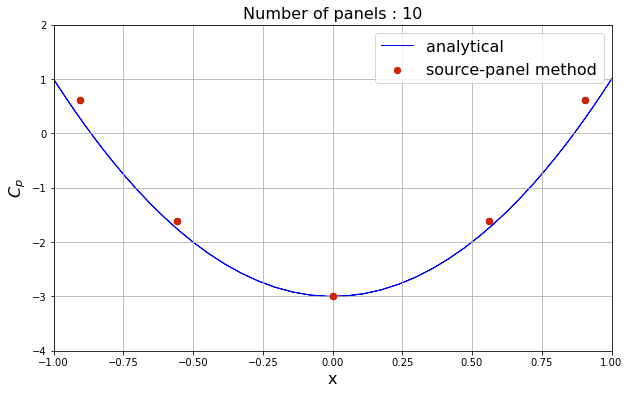

In [15]:
# calculate the analytical surface pressure coefficient
cp_analytical = 1.0 - 4 * (y_cylinder / R)**2

# plot the surface pressure coefficient
pyplot.figure(figsize=(10, 6))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('$C_p$', fontsize=16)
pyplot.plot(x_cylinder, cp_analytical,
            label='analytical',
            color='b', linestyle='-', linewidth=1, zorder=1)
pyplot.scatter([p.xc for p in panels], [p.cp for p in panels],
               label='source-panel method',
               color='#CD2305', s=40, zorder=2)
pyplot.title('Number of panels : %d' % N_panels, fontsize=16)
pyplot.legend(loc='best', prop={'size':16})
pyplot.xlim(-1.0, 1.0)
pyplot.ylim(-4.0, 2.0);